In [1]:
import json
import numpy as np
from pycocotools.coco import COCO
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io as io
import random
import pandas as pd

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 15)

In [2]:
# 두 변수는 각자 데이터 경로에 따라 변경 필요
dataset_dir = "/opt/ml/segmentation/input/data/"
train_json_dir = dataset_dir + "train_all.json"

In [3]:
# json 파일을 읽고 key별로 정보 저장
with open(train_json_dir, 'r') as f:
    train_json = json.loads(f.read())
    
images = train_json['images']
categories = train_json['categories']
annotations = train_json['annotations']

# categories_names: category_id와 이름을 매핑해주는 변수
categories_names = ['None']
for cat_dict in categories:
    categories_names.append(cat_dict['name'])
    
# coco: train_json파일을 COCO api형태로 불러온 변수
coco = COCO(train_json_dir)

loading annotations into memory...
Done (t=5.47s)
creating index...
index created!


# 1. 데이터 시각화

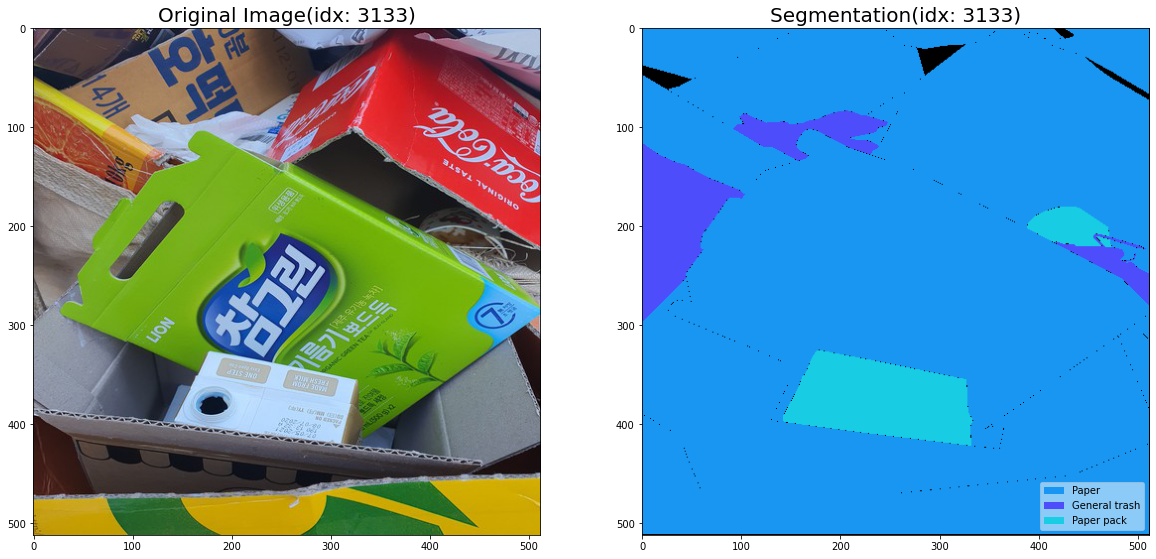

In [4]:
'''
카테고리에 해당하는 색상을 리턴해주는 함수
'''
def category_id_to_color(category_id):
    return plt.cm.rainbow(np.linspace(0, 1.0, 11)[category_id])[:3]


'''
해당 id의 이미지의
1) 원본 이미지
2) segmentation이 표시된 이미지
를 동시에 출력해주는 함수
'''
def show_original_segmentation(idx):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # 원본 이미지
    img = io.imread(os.path.join(dataset_dir, images[idx]['file_name']))
    ax1.imshow(img)

    # segmentation이 표시된 이미지
    ann_ids = coco.getAnnIds(imgIds=idx) # 해당 이미지에 해당하는 annotation id들을 저장한 리스트
    ann = coco.loadAnns(ann_ids) # 해당 이미지에 해당하는 annotation 정보를 모두 담은 리스트
    mask = np.zeros((images[0]['height'], images[0]['width'], 3))
    legend_colors = [] # 사진에 포함된 카테고리에 해당하는 색상을 저장 (추후 범례 표시를 위해)
    legend_titles = [] # 사진에 포함된 카테고리 이름을 저장 (추후 범례 표시를 위해)
    for ele in ann:
        category_id = ele['category_id']
        category = categories_names[category_id]
        color = category_id_to_color(category_id)
        mask[coco.annToMask(ele) == 1] = color
        if category not in legend_titles:
            legend_colors.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, fill=True))
            legend_titles.append(category)
    ax2.imshow(mask)

    ax1.set_title(f"Original Image(idx: {idx})", fontsize=20)
    ax2.set_title(f"Segmentation(idx: {idx})", fontsize=20)
    ax2.legend(legend_colors, legend_titles, loc='lower right', framealpha=.5)
    plt.show()
    
idx = random.randint(0, len(images)-1) # 시각화하기위한 이미지 idx(랜덤배정)
show_original_segmentation(idx)

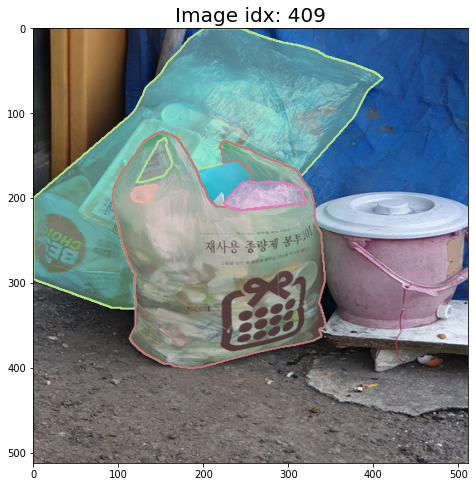

In [5]:
# COCO API를 활용하여 이미지위의 segmentation 시각화하기
def show_coco_api(idx):
    I = io.imread(os.path.join(dataset_dir, images[idx]['file_name']))
    plt.figure(figsize=(8,8))
    plt.title(f"Image idx: {idx}", fontsize=20)
    plt.imshow(I)

    img = coco.loadImgs(idx)[0]
    catIds = coco.getCatIds()

    ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    ann = coco.loadAnns(ann_ids)
    coco.showAnns(ann)
    
    
idx = random.randint(0, len(images)-1) # 시각화하기위한 이미지 idx(랜덤배정)
show_coco_api(idx)

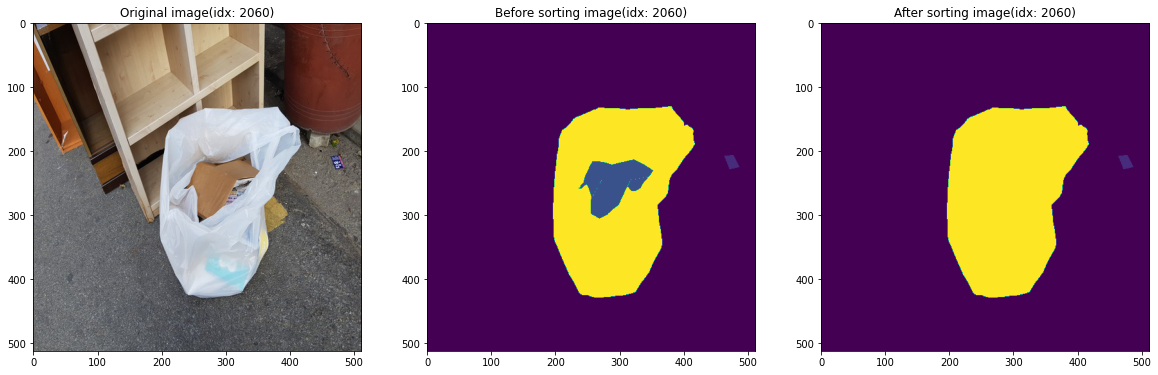

In [6]:
'''
해당 id의 이미지에 대해
1) 원본 이미지
2) 일반적인 segmentation
3) baseline에서 주어진 sort 방식을 적용한 segmentation
위의 3가지의 이미지를 출력
'''
def show_original_segmentation_baseline(idx):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # 원본 이미지
    img = io.imread(os.path.join(dataset_dir, images[idx]['file_name']))
    ax1.imshow(img)

    # 일반적인 segmentaion
    ann_ids = coco.getAnnIds(imgIds=idx)
    ann = coco.loadAnns(ann_ids)
    mask = np.zeros((images[0]['height'], images[0]['width']))
    for ele in ann:
        category_id = ele['category_id']
        category = categories_names[category_id]
        mask[coco.annToMask(ele) == 1] = category_id
    ax2.imshow(mask)

    # baseline에서 주어진 sort 방식을 적용한 segmentation
    ann = sorted(ann, key=lambda x : len(x['segmentation'][0]), reverse=False)
    mask = np.zeros((images[0]['height'], images[0]['width']))
    for ele in ann:
        category_id = ele['category_id']
        category = categories_names[category_id]
        mask[coco.annToMask(ele) == 1] = category_id
    ax3.imshow(mask)

    ax1.set_title(f"Original image(idx: {idx})")
    ax2.set_title(f"Before sorting image(idx: {idx})")
    ax3.set_title(f"After sorting image(idx: {idx})")

    plt.show()

idx = random.randint(1,3000)
# idx = 1868
idx = 2060
show_original_segmentation_baseline(idx)

# 2. plastic bag안에 general trash가 있는 경우 시각화

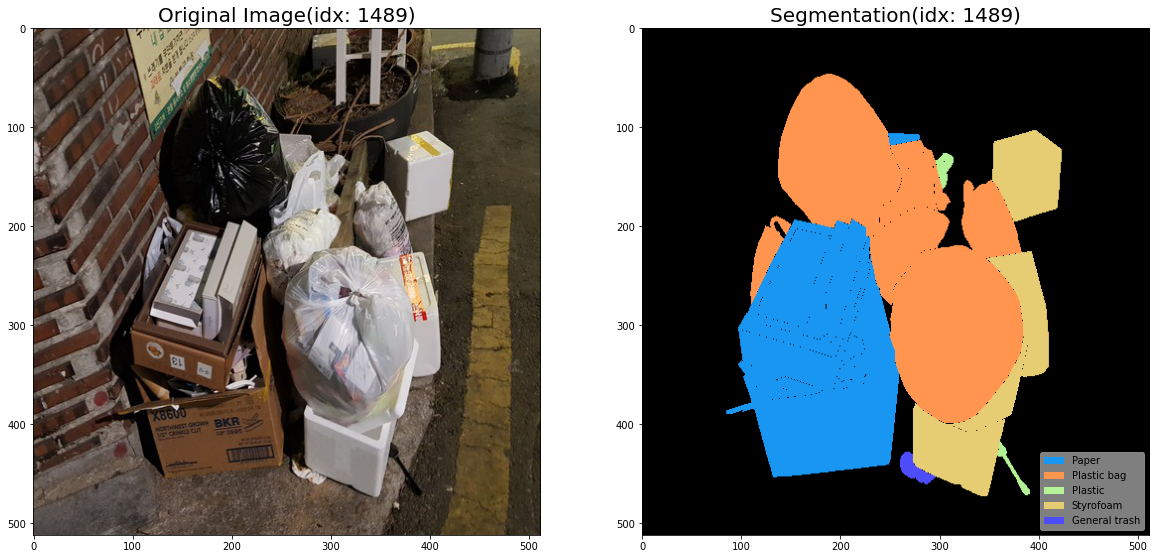

In [7]:
'''
아래 함수는 투명한 비닐백 안에서 비춰지는 물체가
과연 segmentation 처리가 되어있는지를 확인하기 위해
작성되었다.

아래 함수는 단순히 plastic bag과 general trash가 모두 등장하는 이미지를
랜덤으로 시각화하기 때문에
원하는 경우(투명한 비닐백 안에 물체가 들어있는 사진)가
바로 나오지 않을 수 있다.

따라서 원하는 경우가 나올 때까지 셀을 재실행하는 것을 권장한다.

직접 돌려본 결과는 아래와 같다.
비닐백 안에 비춰지는 물체를 segmentation 하지 않은 경우: 대부분
비닐백 안에 비춰지는 물체를 segmentation 한 예시: 466, 1770, 1044, 1674, 1611, 1093, 618
* 특이 케이스
비닐백에 비춰지는 물체가 아님에도 불구하고 segmentation이 안됨: 3209
'''
def show_plastic_and_general_trash():
    while True:
        idx = random.randint(0, len(images)-1)
        # idx = 466

        flag_general_trash = False
        flag_plastic_bag = False

        # 먼저 해당 id의 이미지에 general trash와 plastic bag이 모두 있는지 확인한다.
        ann_ids = coco.getAnnIds(imgIds=idx) # 해당 이미지에 해당하는 annotation id들을 저장한 리스트
        ann = coco.loadAnns(ann_ids) # 해당 이미지에 해당하는 annotation 정보를 모두 담은 리스트
        legend_colors = []
        legend_titles = []
        for ele in ann:
            if ele['category_id'] == 1:
                flag_general_trash = True
            elif ele['category_id'] == 8:
                flag_plastic_bag = True
        if (not flag_general_trash) or (not flag_plastic_bag): # 둘중 하나라도 없다면 다시 처음으로 돌아간다.
            continue

        fig, (ax1, ax2) = plt.subplots(1, 2)
        # 원본 이미지
        img = io.imread(os.path.join(dataset_dir, images[idx]['file_name']))
        ax1.imshow(img)

        # segmetation이 표시된 이미지
        mask = np.zeros((images[0]['height'], images[0]['width'], 3))
        for ele in ann:
            category_id = ele['category_id']
            category = categories_names[category_id]
            color = category_id_to_color(category_id)
            mask[coco.annToMask(ele) == 1] = color
            if category not in legend_titles:
                legend_colors.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, fill=True))
                legend_titles.append(category)
        ax2.imshow(mask)
        
        ax1.set_title(f"Original Image(idx: {idx})", fontsize=20)
        ax2.set_title(f"Segmentation(idx: {idx})", fontsize=20)
        ax2.legend(legend_colors, legend_titles, loc='lower right', framealpha=.5)
        plt.show()
        break


show_plastic_and_general_trash()

# 3. [Segmentation(1)] 카테고리별 segmentation 개수

### 시작하기 앞서 여기서의 'segmentation 개수'의 의미는 '붙어있지 않은 segentation 개수'를 의미합니다.
### 서로 다른 instance일 수도 있고, 또는 중간에 어떠한 물체(ex. 나뭇가지)로 인해 segmentation이 분리된 경우일 수도 있습니다. 

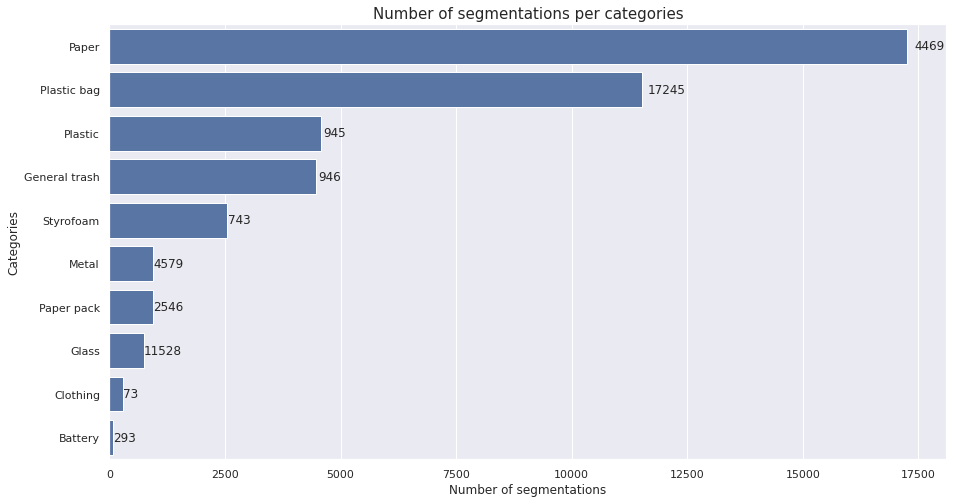

In [8]:
import seaborn as sns

# category_to_num_seg[i]의 의미: category id가 'i'인 카테고리에 대해 
#                                train dataset에 등장하는 총 segmentation 개수를 의미한다.
category_to_num_seg = np.zeros(len(categories_names), dtype=int)
for annotation in annotations:
    category_to_num_seg[annotation['category_id']] += len(annotation['segmentation'])
    
# df: 카테고리와 해당 카테고리의 총 segmentation개수 정보를 가지고 있는 pd.DataFrame 형태의 변수
df = pd.DataFrame({'Categories': categories_names[1:], 'Number of segmentations': category_to_num_seg[1:]})
df = df.sort_values(by='Number of segmentations', axis=0, ascending=False)

# 카테고리별 segmentation 개수 정보를 막대그래프로 시각화
sns.set(rc = {'figure.figsize':(15,8)})
bat_plot = sns.barplot(x="Number of segmentations", y="Categories", data=df, label="Total", color="b")
bat_plot.set_title("Number of segmentations per categories", fontsize=15)
# 막대그래프의 값 표시를 위해 아래 for문 작성
for i, p in enumerate(bat_plot.patches):
    x, y, width, height = p.get_bbox().bounds
    bat_plot.text(width*1.01, y+height/2, df['Number of segmentations'][i], va='center')

# 4. [Segmentation(2)] 하나의 이미지당 segmentation 개수

In [9]:
images_len = len(images)
total_segments_num = sum(category_to_num_seg)
print(f"총 훈련 이미지 개수: {images_len}")
print(f"총 segmentation 개수(=instance 개수): {total_segments_num}")
print(f"하나의 이미지당 segmentation 개수 평균: {total_segments_num/images_len:.2f}")

총 훈련 이미지 개수: 3272
총 segmentation 개수(=instance 개수): 43367
하나의 이미지당 segmentation 개수 평균: 13.25


# 5. [Segmentation(3)] 카테고리별 segmentation 면적 분포

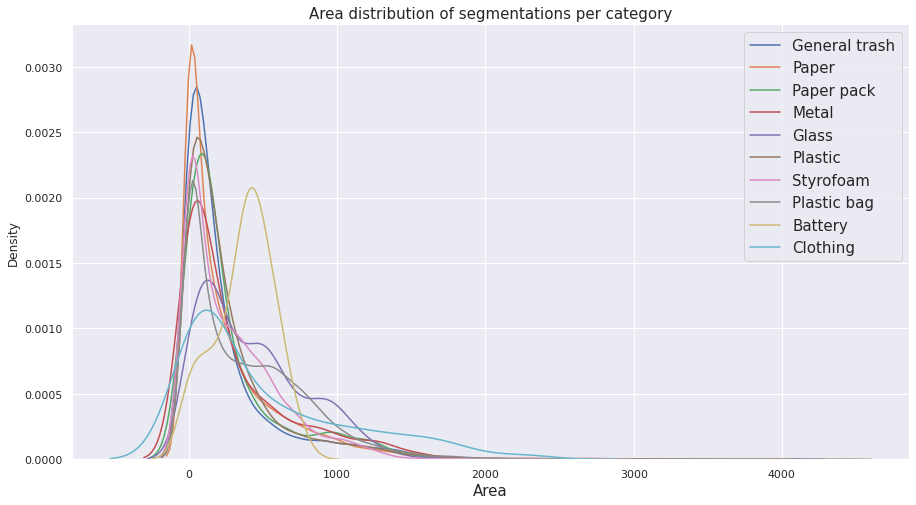

In [10]:
# category_to_area_seg: 카테고리별로 이미지에 등장하는 segmentation 정보들을 list 형태로 저장
category_to_area_seg = [[] for i in range(len(categories_names))]
for annotation in annotations:
    category = annotation['category_id']
    for seg in annotation['segmentation']:
        area = len(seg) / 2
        category_to_area_seg[category].append(area)

# category 별로 segmentation 면적 분포도를 kdeplot으로 시각화
for idx_category in range(1, len(category_to_num_seg)):
    sns.kdeplot(category_to_area_seg[idx_category], label=categories_names[idx_category])

plt.title("Area distribution of segmentations per category", fontsize=15)
plt.xlabel("Area", fontsize=15)
plt.rc('legend', fontsize=15)
plt.legend()
plt.show()

# 6. [Segmentation(4)] (카테고리 상관없이) segmentation 면적 분포

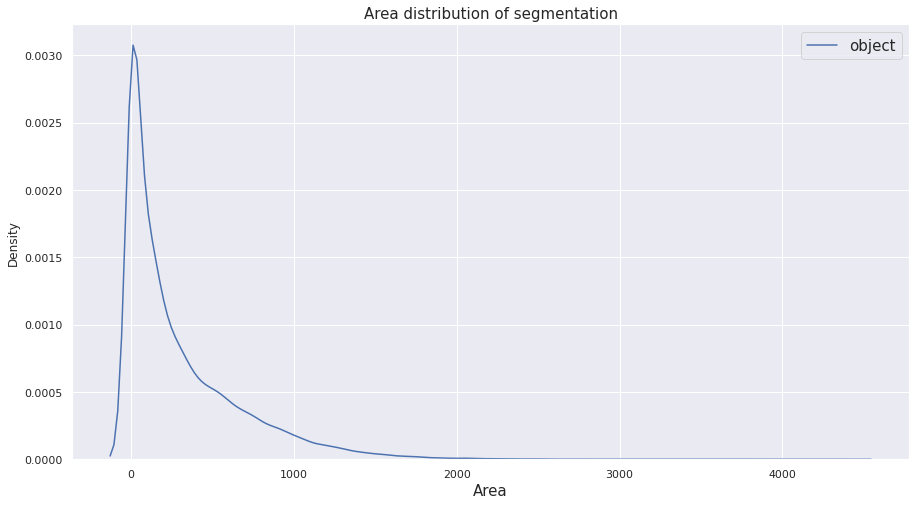

In [11]:
# total_to_area_seg: 위의 category_to_area_seg는 카테고리별로 segmentation 면적 정보를 list로 저장했다면,
#                    total_to_area_seg는 카테고리와는 상관없이 train dataset에 등장하는 segmentation 면적 정보를 저장한다.
total_to_area_seg = []
for idx_category in range(1, len(category_to_area_seg)):
    total_to_area_seg += category_to_area_seg[idx_category]

# segmentation 면적 분포도를 kdeplot으로 시각화
sns.kdeplot(total_to_area_seg, label='object')

plt.title("Area distribution of segmentation", fontsize=15)
plt.xlabel("Area", fontsize=15)
plt.rc('legend', fontsize=15)
plt.legend()
# plt.xlim(0,500)
plt.show()

In [12]:
print(f"평균 segmentation 면적: {sum(total_to_area_seg)/len(total_to_area_seg):.2f}")

평균 segmentation 면적: 303.16


# 7. [Bounding box(1)] 카테고리별 bounding box 개수

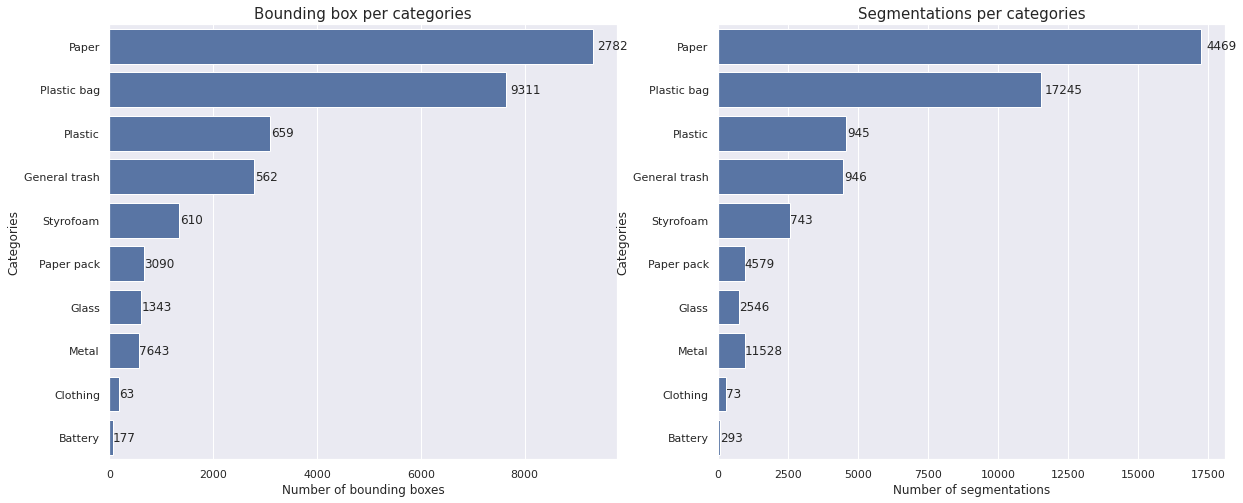

In [13]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(20,8)})
# 위의 segmentation 정보와 비교해보기 위해 axis를 2개 설정하였다.
fig, (ax1, ax2) = plt.subplots(1,2) # ax1: bounding box / ax2: segmentations

# 카테고리별 bounding box개수
category_to_num_bbox = np.zeros(len(categories_names), dtype=int)
for annotation in annotations:
    category_to_num_bbox[annotation['category_id']] += 1

# 카테고리별 segmentation개수
category_to_num_seg = np.zeros(len(categories_names), dtype=int)
for annotation in annotations:
    category_to_num_seg[annotation['category_id']] += len(annotation['segmentation'])
    
df = pd.DataFrame({'Categories': categories_names[1:], \
                   'Number of bounding boxes': category_to_num_bbox[1:],\
                   'Number of segmentations': category_to_num_seg[1:]})
df = df.sort_values(by='Number of bounding boxes', axis=0, ascending=False)
# 카테고리별 bounding box개수를 barplot으로 시각화
plot_1 = sns.barplot(x="Number of bounding boxes", y="Categories", data=df, label="Total", color="b", ax=ax1)
# 카테고리별 segmentation개수를 barplot으로 시각화
plot_2 = sns.barplot(x="Number of segmentations", y="Categories", data=df, label="Total", color="b", ax=ax2)

# ax1의 제목과 막대그래프 수치 표현을 위해 작성
ax1.set_title("Bounding box per categories", fontsize=15)
for i, p in enumerate(plot_1.patches):
    x, y, width, height = p.get_bbox().bounds
    plot_1.text(width*1.01, y+height/2, df['Number of bounding boxes'][i], va='center')
    
# ax2의 제목과 막대그래프 수치 표현을 위해 작성
ax2.set_title("Segmentations per categories", fontsize=15)
for i, p in enumerate(plot_2.patches):
    x, y, width, height = p.get_bbox().bounds
    plot_2.text(width*1.01, y+height/2, df['Number of segmentations'][i], va='center')


# 8. [Bounding box(2)] 하나의 이미지당 bounding box 개수

In [14]:
images_len = len(images)
total_num_bbox = sum(category_to_num_bbox)
print(f"총 훈련 이미지 개수: {images_len}")
print(f"총 bounding box 개수: {total_num_bbox}")
print(f"하나의 이미지당 bounding box 개수 평균: {total_num_bbox/images_len:.2f}")
print("\n")

images_len = len(images)
total_segments_num = sum(category_to_num_seg)
print(f"총 훈련 이미지 개수: {images_len}")
print(f"총 segmentation 개수(=instance 개수): {total_segments_num}")
print(f"하나의 이미지당 segmentation 개수 평균: {total_segments_num/images_len:.2f}")

총 훈련 이미지 개수: 3272
총 bounding box 개수: 26240
하나의 이미지당 bounding box 개수 평균: 8.02


총 훈련 이미지 개수: 3272
총 segmentation 개수(=instance 개수): 43367
하나의 이미지당 segmentation 개수 평균: 13.25


# 9. [Bounding box(3)] 카테고리별 bounding box 면적 분포

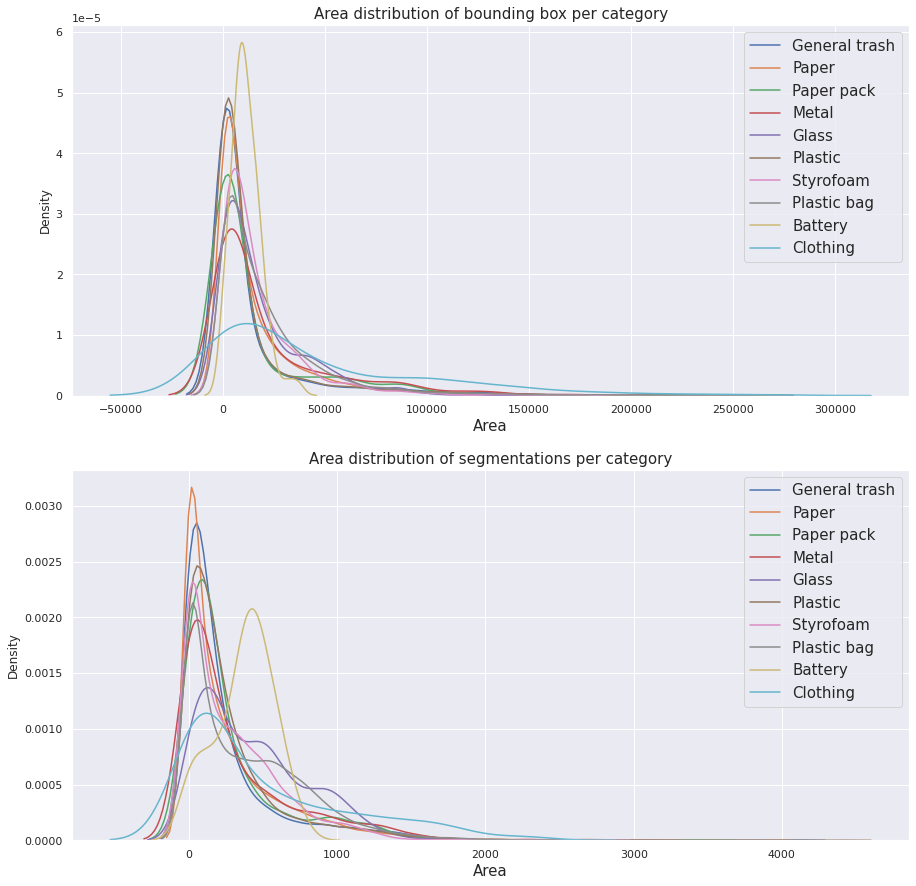

In [15]:
sns.set(rc = {'figure.figsize':(15,15)})
# segmentation 정보와 비교해보기 위해 axis를 2개 설정하였다.
fig, (ax1, ax2) = plt.subplots(2,1) # ax1: bounding box / ax2: segmentations

# category_to_area_bbox: 카테고리별 bouning box 면적정보를 리스트형태로 저장
category_to_area_bbox = [[] for i in range(len(categories_names))]
for annotation in annotations:
    category = annotation['category_id']
    bbox = annotation['bbox']
    area = bbox[2]*bbox[3]
    category_to_area_bbox[category].append(area)
    
# 카테고리별 bounding box 면적 분포를 kdeplot으로 시각화
for idx_category in range(1, len(category_to_num_bbox)):
    sns.kdeplot(category_to_area_bbox[idx_category], label=categories_names[idx_category], ax=ax1)

# 카테고리별 segmentation 면적 분포를 kdeplot으로 시각화
for idx_category in range(1, len(category_to_num_seg)):
    sns.kdeplot(category_to_area_seg[idx_category], label=categories_names[idx_category], ax=ax2)
    
plt.rc('legend', fontsize=15)
ax1.legend()
ax1.set_title("Area distribution of bounding box per category", fontsize=15)
ax1.set_xlabel("Area", fontsize=15)

ax2.legend()
ax2.set_title("Area distribution of segmentations per category", fontsize=15)
ax2.set_xlabel("Area", fontsize=15)
plt.show()

# 10. [Bounding box(4)] (카테고리 상관없이) bounding box 면적 분포

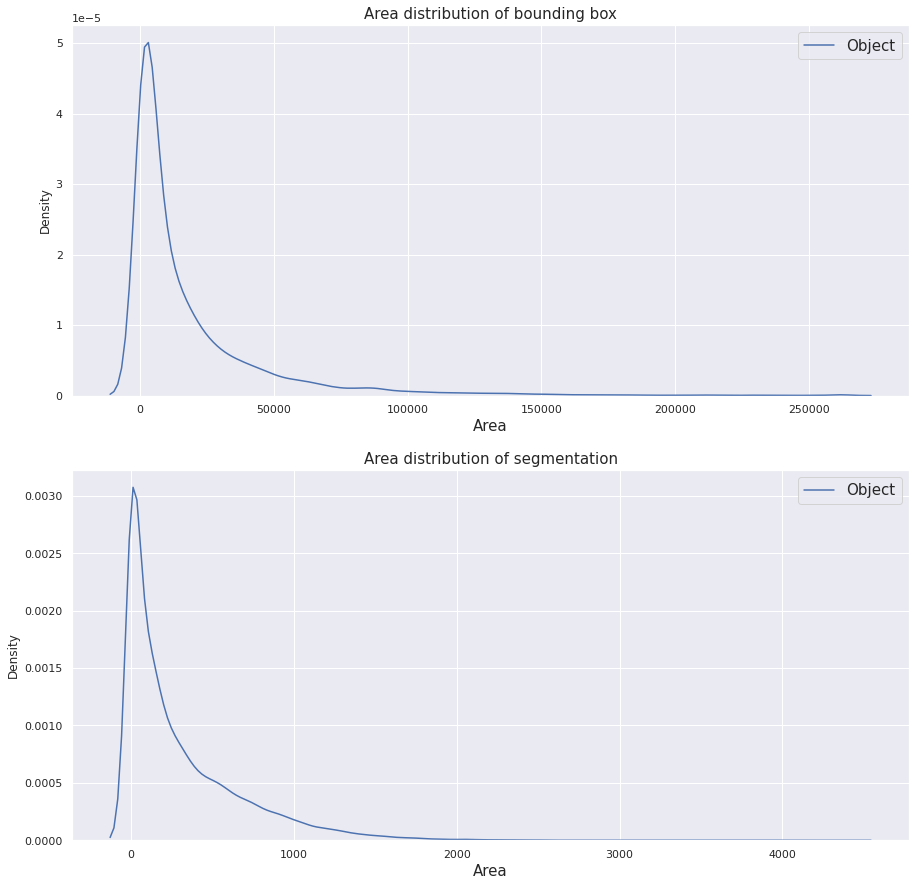

In [16]:
# segmentation 정보와 비교해보기 위해 axis를 2개 설정하였다.
fig, (ax1, ax2) = plt.subplots(2,1) # ax1: bounding box / ax2: segmentations

# total_to_area_bbox: 카테고리 상관없이 bounding box 면적정보를 리스트형태로 저장한다.
total_to_area_bbox = []
for idx_category in range(1, len(category_to_area_bbox)):
    total_to_area_bbox += category_to_area_bbox[idx_category]

# bounding box 면적 분포를 kdeplot으로 시각화
sns.kdeplot(total_to_area_bbox, label='Object', ax=ax1)
# segmentation 면적 분포를 kdeplot으로 시각화
sns.kdeplot(total_to_area_seg, label='Object', ax=ax2)

plt.rc('legend', fontsize=15)
ax1.set_title("Area distribution of bounding box", fontsize=15)
ax1.legend()
ax1.set_xlabel("Area", fontsize=15)
ax2.set_title("Area distribution of segmentation", fontsize=15)
ax2.legend()
ax2.set_xlabel("Area", fontsize=15)
# plt.xlim(0,500)
plt.show()

In [17]:
print(f"평균 bounding box 면적: {sum(total_to_area_bbox)/len(total_to_area_bbox):.2f}")
print(f"평균 segmentation 면적: {sum(total_to_area_seg)/len(total_to_area_seg):.2f}")

평균 bounding box 면적: 18132.31
평균 segmentation 면적: 303.16
